In [70]:
import pynumdiff
import numpy as np
import cvxpy
import matplotlib.pyplot as plt
import copy

# Simulate full lorenz system

In [71]:
# Simulation parameters
noise_parameters = [0, 0.1]
dt = 0.01

In [72]:
noisy_measurements, actual_vals, extras = pynumdiff.utils.simulate.lorenz_xyz(noise_parameters=noise_parameters,
                                                                              dt=dt)
x = noisy_measurements[0,:]
y = noisy_measurements[1,:]
z = noisy_measurements[2,:]

xdot_actual = actual_vals[3,:]
ydot_actual = actual_vals[4,:]
zdot_actual = actual_vals[5,:]

Text(0,0.5,'z')

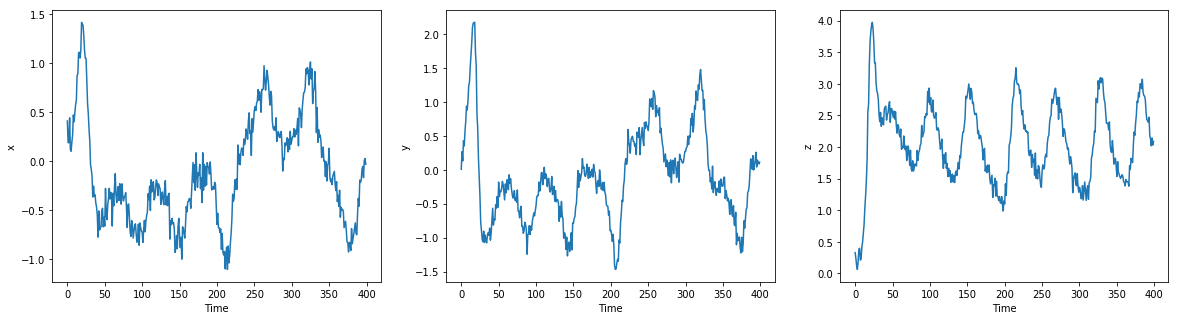

In [73]:
fig = plt.figure(figsize=(20,5))

ax = fig.add_subplot(1,3,1)
ax.plot(x)
ax.set_xlabel('Time')
ax.set_ylabel('x')

ax = fig.add_subplot(1,3,2)
ax.plot(y)
ax.set_xlabel('Time')
ax.set_ylabel('y')

ax = fig.add_subplot(1,3,3)
ax.plot(z)
ax.set_xlabel('Time')
ax.set_ylabel('z')

# PySINDy Integral Form

### SINDy requires the user to provide a library of features, which can be nonlinear combinations of the states

For the integral form of SINDy, we simply integrate these features and compare them to x,y,z, instead of xdot, ydot, zdot.

In [130]:
def integrate_library(library, dt):
    library = [np.cumsum(l)*dt for l in library]
    return library

In [131]:
def get_library(x, y, z):
    library = [x, y, z, x**2, y**2, z**2, x*y, x*z, y*z, x*y*z, np.ones_like(x)]
    return library

### To treat each feature equally in the optimization, we first need to whiten the inputs and the derivatives (e.g. mean=0 / std=1)
We save the whitening parameters so that we can later undo the whitening

In [132]:
class DeWhiten(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def dewhiten(self, m):
        return (m+self.mean)*self.std

In [133]:
def whiten_library(library):
    white_library = []
    dewhiten = []
    for m in library:
        m += 2*(np.random.random(len(m))-0.5)*1e-8 # in case we have a pure constant
        
        std_m = np.std(m)**2
        mean_m = np.mean(m)
        
        white_m = (m-mean_m)/std_m
        white_library.append(white_m)

        dewhiten.append(DeWhiten(mean_m, std_m))
    return white_library, dewhiten

In [134]:
# Features
library = get_library(x, y, z)
integrated_library = integrate_library(library, dt)
white_integrated_library, dewhiten_integrated_library = whiten_library(integrated_library)

# Whitened states
white_states, dewhiten_states = whiten_library([x, y, z])
white_x, white_y, white_z = white_states

### Solve the optimization problem

In [148]:
# Setup convex optimization problem

var = cvxpy.Variable( (3, len(integrated_library)) )

sum_squared_error_x = cvxpy.sum_squares( white_x - white_integrated_library*var[0,:] )
sum_squared_error_y = cvxpy.sum_squares( white_y - white_integrated_library*var[1,:] )
sum_squared_error_z = cvxpy.sum_squares( white_z - white_integrated_library*var[2,:] )

sum_squared_error = cvxpy.sum([sum_squared_error_x, 
                               sum_squared_error_y, 
                               sum_squared_error_z])

In [149]:
# Optimization parameters
gamma = 5
solver = 'MOSEK'

In [150]:
# Solve convex optimization problem
L = cvxpy.sum( sum_squared_error + gamma*cvxpy.norm1(var) )
obj = cvxpy.Minimize(L)
prob = cvxpy.Problem(obj)
r = prob.solve(solver=solver)
sindy_coefficients = var.value

### Now we undo the whitening

In [151]:
# dewhiten library coefficients

integrated_library_std = []
integrated_library_mean = []
for d in dewhiten_integrated_library:
    integrated_library_std.append(d.std)
    integrated_library_mean.append(d.mean)
integrated_library_std = np.array(integrated_library_std)
integrated_library_mean = np.array(integrated_library_mean)

In [152]:
# dewhiten state coefficients

state_std = []
state_mean = []
for d in dewhiten_states:
    state_std.append(d.std)
    state_mean.append(d.mean)
state_std = np.array(state_std)
state_mean = np.array(state_mean)

In [153]:
integrated_library_offset = np.matrix(sindy_coefficients/integrated_library_std)*np.matrix(integrated_library_mean).T

### These are the parameters for the original (non-white) data

In [154]:
estimated_coefficients = sindy_coefficients/integrated_library_std*np.tile(state_std, [len(integrated_library), 1]).T
offset = -1*(state_std*np.ravel(integrated_library_offset)) + state_mean

### Verify that we are able to estimate x,y,z using the discovered parameters

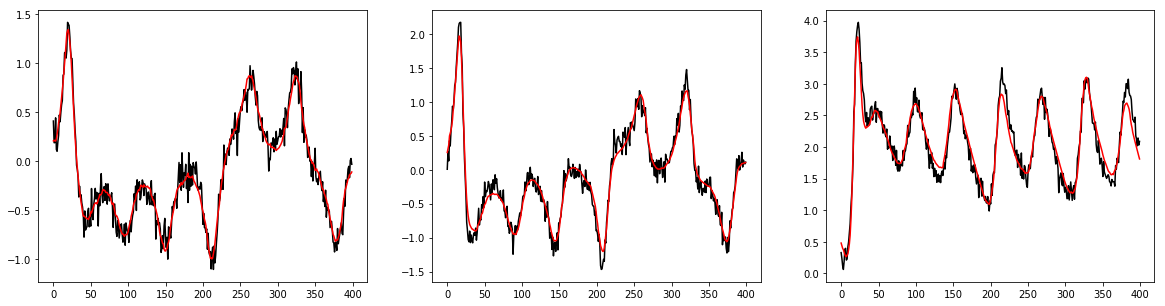

In [155]:
fig = plt.figure(figsize=(20,5))
i_to_s = {0: 'x', 1: 'y', 2: 'z'}
for i in range(0,3):
    sdot_rec = np.matrix(estimated_coefficients[i,:])*np.matrix(integrated_library) + offset[i]
    
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(eval(i_to_s[i]), color='black')
    ax.plot(sdot_rec.T, color='red')

# Now estimate the derivatives

This step simply takes the coefficients discovered 

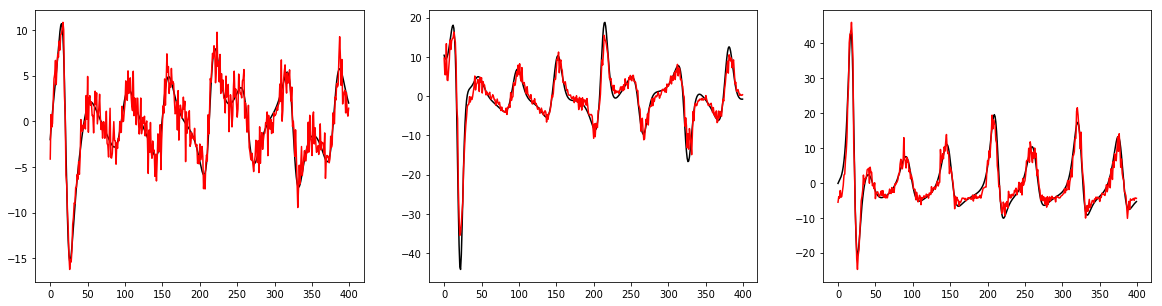

In [156]:
fig = plt.figure(figsize=(20,5))
i_to_s = {0: 'x', 1: 'y', 2: 'z'}
for i in range(0,3):
    sdot_rec = np.matrix(estimated_coefficients[i,:])*np.matrix(library) #+ offset[i]
    
    ax = fig.add_subplot(1,3,i+1)
    ax.plot(eval(i_to_s[i] + 'dot_actual'), color='black')
    ax.plot(sdot_rec.T, color='red')

In [157]:
xdot_rec = np.matrix(estimated_coefficients[0,:])*np.matrix(library)
window_size = 15
kernel = pynumdiff.utils.utility.__gaussian_kernel__(window_size)
xdot_rec = pynumdiff.smooth_finite_difference.__convolutional_smoother__(np.ravel(xdot_rec), kernel, 1)

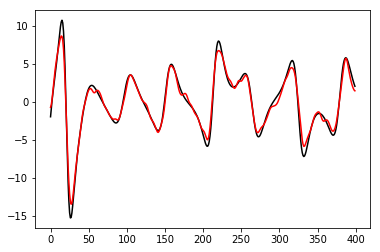

In [158]:
plt.plot(xdot_actual, 'black')
plt.plot(xdot_rec, 'red')

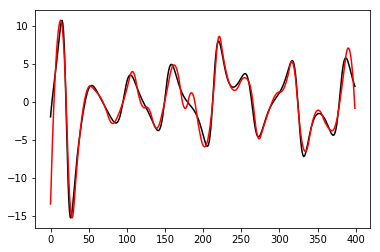

In [159]:
jxsmooth, jxdot = pynumdiff.total_variation_regularization.jerk(x, dt, 5)
plt.plot(xdot_actual, 'black')
plt.plot(jxdot, 'red')

In [160]:
estimated_coefficients

array([[-1.02227750e+01,  1.01103549e+01, -1.50747289e-11,
        -9.94395168e-09, -6.94480657e-02, -1.44397740e-12,
        -2.02359135e-08, -4.97003332e-09,  2.99909559e-10,
        -6.70908150e-10, -1.60696505e-10],
       [ 2.84146760e+01,  2.86542881e+00, -8.62225801e-11,
        -3.36011843e-01, -5.17891010e-11, -5.93964302e-12,
        -4.45201964e-08, -1.44192523e+01, -6.30048373e-09,
        -1.93438642e-09, -1.09051861e-09],
       [-2.80820898e-01, -1.67011885e+00, -5.21482173e-10,
        -6.21233510e+00,  1.01486345e-08, -3.05257663e-11,
         2.24979253e+01, -1.16721085e-08,  1.16977342e+00,
         1.02490543e-09, -4.43463459e+00]])